## 6.01 - Supervised Learning Model Comparison

Recall the "data science process."

1. Define the problem.
2. Gather the data.
3. Explore the data.
4. Model the data.
5. Evaluate the model.
6. Answer the problem.

In this lab, we're going to focus mostly on creating (and then comparing) many regression and classification models. Thus, we'll define the problem and gather the data for you.

Most of the questions requiring a written response can be written in 2-3 sentences.

In [232]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVR,SVC
from sklearn.metrics import mean_squared_error,f1_score

### Step 1: Define the problem.

You are a data scientist with a financial services company. Specifically, you want to leverage data in order to identify potential customers.

If you are unfamiliar with "401(k)s" or "IRAs," these are two types of retirement accounts. Very broadly speaking:
- You can put money for retirement into both of these accounts.
- The money in these accounts gets invested and hopefully has a lot more money in it when you retire.
- These are a little different from regular bank accounts in that there are certain tax benefits to these accounts. Also, employers frequently match money that you put into a 401k.
- If you want to learn more about them, check out [this site](https://www.nerdwallet.com/article/ira-vs-401k-retirement-accounts).

We will tackle one regression problem and one classification problem today.
- Regression: What features best predict one's income?
- Classification: Predict whether or not one is eligible for a 401k.

Check out the data dictionary [here](http://fmwww.bc.edu/ec-p/data/wooldridge2k/401KSUBS.DES).

### NOTE: When predicting `inc`, you should pretend as though you do not have access to the `e401k`, the `p401k` variable, and the `pira` variable. When predicting `e401k`, you may use the entire dataframe if you wish.

### Step 2: Gather the data.

##### 1. Read in the data from the repository.

In [197]:
df = pd.read_csv('401ksubs.csv')
df.head()

,e401k,inc,marr,male,age,fsize,nettfa,p401k,pira,incsq,agesq
0,0,13.170,0,0,40,1,4.575,0,1,173.4489,1600
1,1,61.230,0,1,35,1,154.000,1,0,3749.1130,1225
2,0,12.858,1,0,44,2,0.000,0,0,165.3282,1936
3,0,98.880,1,1,44,2,21.800,0,0,9777.2540,1936
4,0,22.614,0,0,53,1,18.450,0,0,511.3930,2809


In [198]:
df.shape

(9275, 11)

In [199]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
e401k,9275.0,0.392129,0.488252,0.0000,0.0000,0.000,1.0000,1.000
inc,9275.0,39.254641,24.090002,10.0080,21.6600,33.288,50.1600,199.041
marr,9275.0,0.628571,0.483213,0.0000,0.0000,1.000,1.0000,1.000
male,9275.0,0.204420,0.403299,0.0000,0.0000,0.000,0.0000,1.000
age,9275.0,41.080216,10.299517,25.0000,33.0000,40.000,48.0000,64.000
fsize,9275.0,2.885067,1.525835,1.0000,2.0000,3.000,4.0000,13.000
nettfa,9275.0,19.071675,63.963838,-502.3020,-0.5000,2.000,18.4495,1536.798
p401k,9275.0,0.276226,0.447154,0.0000,0.0000,0.000,1.0000,1.000
pira,9275.0,0.254340,0.435513,0.0000,0.0000,0.000,1.0000,1.000
incsq,9275.0,2121.192483,3001.469424,100.1601,469.1556,1108.091,2516.0255,39617.320


### Data Dictionary
|Variable Name|Storage Type|Variable Label|
|--|--|--|
|e401k|byte|=1 if eligble for 401(k)|
|inc|float|~~inc^2~~ income|
|marr|byte|=1 if married|
|male|byte|=1 if male respondent|
|age|byte|~~age^2~~ age|
|fsize|byte|family size|
|nettfa|float|net total fin. assets, $1000|
|p401k|byte|=1 if participate in 401(k)|
|pira|byte|=1 if have IRA|
|incsq|float|inc^2|
|agesq|int|age^2|


##### 2. What are 2-3 other variables that, if available, would be helpful to have?

1. Education Background (Bachelor/ Master Degree)
2. Industry
3. Working Experience Duration

##### 3. Suppose a peer recommended putting `race` into your model in order to better predict who to target when advertising IRAs and 401(k)s. Why would this be an unethical decision?

This can be unethical because the goal of both IRA and 401k is to have a retirement savings for your future. By specifying the race, we are indicating that a specific race might have better accessibility than the other which is not the case. Both retirement savings plan should be accesible for all people despite their race

## Step 3: Explore the data.

##### 4. When attempting to predict income, which feature(s) would we reasonably not use? Why?

First, we will exclude the target prediction which is the income and square of income
Second, if I would to exclude the e401k, p401k and pira features, the next one that I will exclude is marr which define whether one is married or not.
I think this feature will have correlation to the family size.

##### 5. What two variables have already been created for us through feature engineering? Come up with a hypothesis as to why subject-matter experts may have done this.
> This need not be a "statistical hypothesis." Just brainstorm why SMEs might have done this!

The potential reason why it might be squared is because these features such as the income and age don't have normal distribution. Squaring it might be one of the ways to normalize the distribution

In [200]:
df.head()

,e401k,inc,marr,male,age,fsize,nettfa,p401k,pira,incsq,agesq
0,0,13.170,0,0,40,1,4.575,0,1,173.4489,1600
1,1,61.230,0,1,35,1,154.000,1,0,3749.1130,1225
2,0,12.858,1,0,44,2,0.000,0,0,165.3282,1936
3,0,98.880,1,1,44,2,21.800,0,0,9777.2540,1936
4,0,22.614,0,0,53,1,18.450,0,0,511.3930,2809


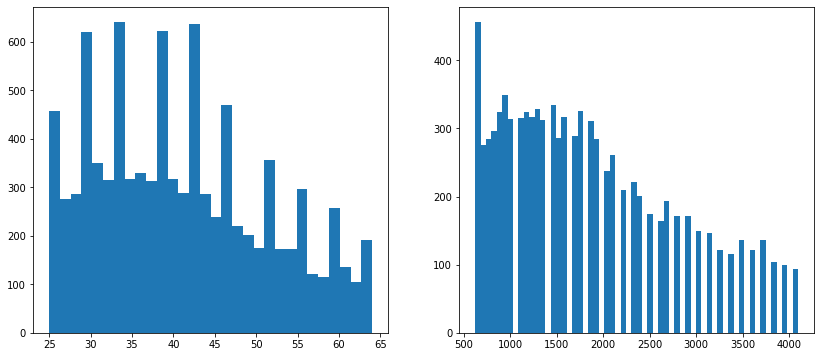

In [201]:
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(14,6))
ax1.hist(df['age'],bins=30);
ax2.hist(df['agesq'],bins=60);

(0.0, 6000.0)

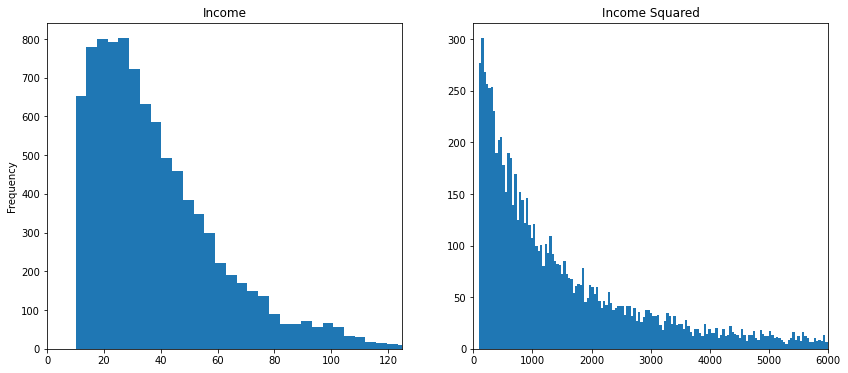

In [202]:
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(14,6))
ax1.hist(df['inc'],bins=50);
ax1.set_title('Income')
ax1.set_xlim([0,125])
ax1.set_ylabel('Frequency')
ax2.hist(df['incsq'],bins=1000);
ax2.set_title('Income Squared')
ax2.set_xlim([0,6000])

##### 6. Looking at the data dictionary, one variable description appears to be an error. What is this error, and what do you think the correct value would be?

For 'inc' and 'age', both of them is labeled as squared of each one of them while it is not as we see the data. 'inc' corresponds to the income and 'age' corresponds to the age

## Step 4: Model the data. (Part 1: Regression Problem)

Recall:
- Problem: What features best predict one's income?
- When predicting `inc`, you should pretend as though you do not have access to the `e401k`, the `p401k` variable, and the `pira` variable.

##### 7. List all modeling tactics we've learned that could be used to solve a regression problem (as of Wednesday afternoon of Week 6). For each tactic, identify whether it is or is not appropriate for solving this specific regression problem and explain why or why not.

1. Linear Regression (Ordinary Least)
    + there is a requirement on data to have linear relationship, variables to be independent and residual must be normally distributed and not have patter. However, there might be a problem of multicollinearity.
    + this model is suitable
2. Knn regressor:
    + sensitive on the distance of the data
    + suitable after scaling
3. Decision Tree Regressor (using gini impurity to determine the node)
    + 1 decision tree might not be able to accurately predict
4. Set of bagged decision trees
    + improvement from decision tree
    + suitable to have better predition, but might have high correlation between trees
5. Random Forest
    + might be a better model to choose rather than decision tree and set of bagged decision trees due to the bootstrapped data that decorrelate the variables
6. Adaboost
    + very strategic process to optimize and strengthen the weak learner
    + a suitable model
7. Support Vector Regressor
    + finding a separation in our data by transforming it to higher dimension through matrix calculation (dot products).
    + can find intricate separation without actually transforming it.
    + suitable model

##### 8. Regardless of your answer to number 7, fit at least one of each of the following models to attempt to solve the regression problem above:
    - a multiple linear regression model
    - a k-nearest neighbors model
    - a decision tree
    - a set of bagged decision trees
    - a random forest
    - an Adaboost model
    - a support vector regressor
    
> As always, be sure to do a train/test split! In order to compare modeling techniques, you should use the same train-test split on each. I recommend setting a random seed here.

> You may find it helpful to set up a pipeline to try each modeling technique, but you are not required to do so!

In [221]:
#define the X and y
X = df.drop(columns=['inc','incsq','e401k','p401k','pira'],axis=1)
y = df['inc']
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=0.2)
#scaling
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [222]:
#creating pipeline and fitting it to our data

models = {
        'Linear Regression':LinearRegression(),
        'k Nearest Neighbor': KNeighborsRegressor(),
        'Decision Tree' : DecisionTreeRegressor(),
        'Set of Bagged Decision Trees': BaggingRegressor(),
        'Random Forest' : RandomForestRegressor(),
        'AdaBoost' : AdaBoostRegressor(),
        'Support Vector Regressor' : SVR(),
    }
for item,model in models.items():
        model.fit(X_train_sc,y_train);
        cross_val = cross_val_score(model,X_train_sc,y_train).mean()
        train_score = model.score(X_train_sc,y_train)
        test_score = model.score(X_test_sc,y_test)
        print(f'Cross validation on training of {item}: {cross_val:.2f}')
        print(f'The training score for {item}: {train_score:.2f}')
        print(f'The test score for {item}: {test_score:.2f}')
        print('--------------------------------------------------')

Cross validation on training of Linear Regression: 0.28
The training score for Linear Regression: 0.29
The test score for Linear Regression: 0.27
--------------------------------------------------
Cross validation on training of k Nearest Neighbor: 0.28
The training score for k Nearest Neighbor: 0.53
The test score for k Nearest Neighbor: 0.32
--------------------------------------------------
Cross validation on training of Decision Tree: -0.25
The training score for Decision Tree: 0.99
The test score for Decision Tree: -0.21
--------------------------------------------------
Cross validation on training of Set of Bagged Decision Trees: 0.26
The training score for Set of Bagged Decision Trees: 0.86
The test score for Set of Bagged Decision Trees: 0.28
--------------------------------------------------
Cross validation on training of Random Forest: 0.30
The training score for Random Forest: 0.90
The test score for Random Forest: 0.32
--------------------------------------------------
C

##### 9. What is bootstrapping?

Bootstrapping is a random sampling method with replacement. It is a method used to create better prediction.

##### 10. What is the difference between a decision tree and a set of bagged decision trees? Be specific and precise!

Decision tree consists of 1 tree only to make prediction while a set of bagged decision trees have multiple trees. There are few advantages of using bagged decision trees compared to decision tree:
1. Statistically: one model will only generate one prediciton while multiple models can average out the errors by each model.
2. Computationally: there is chance that our prediction is in the local mininum, while having multiple models enable us to get the global minimum value
3. Representation: one model might not be able to accurately predict the target value, but having multiple models and aggregate the result will enable better prediction

##### 11. What is the difference between a set of bagged decision trees and a random forest? Be specific and precise!

The difference between set of bagged decision trees and random forest are:
1. Number of features used in the model. Bagged decision trees will utilize all the features while random forest utilize bootstrapped data, therefore, not all the features is used to make prediction
2. Random forest reduces the variance with the expense of increasing the bias by decorelatting the trees as we select random subset of the features. 

##### 12. Why might a random forest be superior to a set of bagged decision trees?
> Hint: Consider the bias-variance tradeoff.

Bagged of decision trees has tendency of being highly correlated (high variance, low bias) due to the Gini Impurity method that the model used to choose which node chosen as parent nod, this is where Random Forest come in with bootstrapped data reducing the variance of the data

## Step 5: Evaluate the model. (Part 1: Regression Problem)

##### 13. Using RMSE, evaluate each of the models you fit on both the training and testing data.

In [207]:
#function for rmse
for item,model in models.items():
        y_pred_train = model.predict(X_train_sc)
        rmse_train = np.sqrt(mean_squared_error(y_train,y_pred_train))
        y_pred_test = model.predict(X_test_sc)
        rmse_test = np.sqrt(mean_squared_error(y_test,y_pred_test))
        print(f'Training data RMSE value by {item}: {rmse_train:.2f}')
        print(f'Testing data RMSE value by {item}: {rmse_test:.2f}')
        print('----------------------------------------------------------------')

Training data RMSE value by Linear Regression: 20.16
Testing data RMSE value by Linear Regression: 20.90
----------------------------------------------------------------
Training data RMSE value by k Nearest Neighbor: 16.50
Testing data RMSE value by k Nearest Neighbor: 20.18
----------------------------------------------------------------
Training data RMSE value by Decision Tree: 2.26
Testing data RMSE value by Decision Tree: 27.28
----------------------------------------------------------------
Training data RMSE value by Set of Bagged Decision Trees: 8.98
Testing data RMSE value by Set of Bagged Decision Trees: 20.93
----------------------------------------------------------------
Training data RMSE value by Random Forest: 7.75
Testing data RMSE value by Random Forest: 20.32
----------------------------------------------------------------
Training data RMSE value by AdaBoost: 21.93
Testing data RMSE value by AdaBoost: 22.99
----------------------------------------------------------

##### 14. Based on training RMSE and testing RMSE, is there evidence of overfitting in any of your models? Which ones?

Yes, if Test data RMSE score is significantly higher than the test set, we can see this as an indication of overfitting.

Well generalizing model: linear regression, support vector regressor

Slight overfit: kNN, AdaBoost

Severe overfitting: Decision Trees, Bagged of Decision Trees, Random Forrest

##### 15. Based on everything we've covered so far, if you had to pick just one model as your final model to use to answer the problem in front of you, which one model would you pick? Defend your choice.

I will choose Support Vector Regressor to predict income because the model generate best R2 score and also lowest RMSE in the well generalizing model category.

##### 16. Suppose you wanted to improve the performance of your final model. Brainstorm 2-3 things that, if you had more time, you would attempt.

2 things that I will do to improve Support Vector Machine performance:
1. Add more relevant features that can better predict income
2. Tuning the hyperparameters using gridsearch

In [208]:
svr = SVR()
final_model_1 = make_pipeline(ss,svr)
svr_params = {
    'svr__kernel':['rbf','poly'],
    'svr__C':[10,1,0.5,0.1],
}
gs_svr = GridSearchCV(
    estimator=final_model_1,
    param_grid=svr_params,
    cv=10,
    n_jobs=-1,
    scoring ='r2',
    return_train_score=True
)
gs_svr.fit(X_train,y_train);

In [209]:
gs_svr.best_params_

{'svr__C': 10, 'svr__kernel': 'rbf'}

In [210]:
print('Train score:',gs_svr.score(X_train,y_train),'Test score:',gs_svr.score(X_test,y_test))
#improvement from our baseline score

Train score: 0.36151579213813057 Test score: 0.34044023614281493


## Step 4: Model the data. (Part 2: Classification Problem)

Recall:
- Problem: Predict whether or not one is eligible for a 401k.
- When predicting `e401k`, you may use the entire dataframe if you wish.

##### 17. While you're allowed to use every variable in your dataframe, mention at least one disadvantage of using `p401k` in your model.

Disadvantage of using p401k variable is it is correlated to the other feature (e401k)

##### 18. List all modeling tactics we've learned that could be used to solve a classification problem (as of Wednesday afternoon of Week 6). For each tactic, identify whether it is or is not appropriate for solving this specific classification problem and explain why or why not.

1. Logistic Regression 
    + perform well if data is linear by getting the probability then classify it to certain class
    + this model is suitable
2. Knn regressor:
    + sensitive on the distance of the data
    + suitable after scaling
3. Decision Tree (using gini impurity to determine the node)
    + 1 decision tree might not be able to accurately predict
4. Set of bagged decision trees
    + improvement from decision tree
    + suitable to have better predition, but might have high correlation between trees
5. Random Forest
    + might be a better model to choose rather than decision tree and set of bagged decision trees due to the bootstrapped data that decorrelate the variables
6. Adaboost
    + very strategic process to optimize and strengthen the weak learner
    + a suitable model
7. Support Vector Classifier
    + finding a separation in our data by transforming it to higher dimension through matrix calculation.
    + can find intricate separation without actually transforming it.
    + suitable model

##### 19. Regardless of your answer to number 18, fit at least one of each of the following models to attempt to solve the classification problem above:
    - a logistic regression model
    - a k-nearest neighbors model
    - a decision tree
    - a set of bagged decision trees
    - a random forest
    - an Adaboost model
    - a support vector classifier
    
> As always, be sure to do a train/test split! In order to compare modeling techniques, you should use the same train-test split on each. I recommend using a random seed here.

> You may find it helpful to set up a pipeline to try each modeling technique, but you are not required to do so!

In [228]:
#Define the X and y 
X = df.drop(columns=['e401k'],axis=1)
y = df['e401k']
#train-test-split 
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=0.2)
#scaling
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [229]:
class_model = {
    'Logistic Regresion':LogisticRegression(),
    'k Nearest Neighbor' : KNeighborsClassifier(),
    'Decision Tree':DecisionTreeClassifier(),
    'Set of Bagged Decision Trees':BaggingClassifier(),
    'Random Forrest':RandomForestClassifier(),
    'AdaBoost':AdaBoostClassifier(),
    'Support Vector Classifier':SVC()
}
for item,model in class_model.items():
        model.fit(X_train_sc,y_train);
        cross_val = cross_val_score(model,X_train_sc,y_train).mean()
        train_score = model.score(X_train_sc,y_train)
        test_score = model.score(X_test_sc,y_test)
        print(f'Cross validation on training of {item}: {cross_val:.2f}')
        print(f'The training score for {item}: {train_score:.2f}')
        print(f'The test score for {item}: {test_score:.2f}')
        print('--------------------------------------------------')

Cross validation on training of Logistic Regresion: 0.88
The training score for Logistic Regresion: 0.88
The test score for Logistic Regresion: 0.89
--------------------------------------------------
Cross validation on training of k Nearest Neighbor: 0.86
The training score for k Nearest Neighbor: 0.89
The test score for k Nearest Neighbor: 0.87
--------------------------------------------------
Cross validation on training of Decision Tree: 0.81
The training score for Decision Tree: 1.00
The test score for Decision Tree: 0.80
--------------------------------------------------
Cross validation on training of Set of Bagged Decision Trees: 0.87
The training score for Set of Bagged Decision Trees: 0.98
The test score for Set of Bagged Decision Trees: 0.87
--------------------------------------------------
Cross validation on training of Random Forrest: 0.88
The training score for Random Forrest: 1.00
The test score for Random Forrest: 0.88
------------------------------------------------

In [230]:
for item,model in class_model.items():
        y_pred_train = model.predict(X_train_sc)
        rmse_train = np.sqrt(mean_squared_error(y_train,y_pred_train))
        y_pred_test = model.predict(X_test_sc)
        rmse_test = np.sqrt(mean_squared_error(y_test,y_pred_test))
        print(f'Training data RMSE value by {item}: {rmse_train:.2f}')
        print(f'Testing data RMSE value by {item}: {rmse_test:.2f}')
        print('----------------------------------------------------------------')

Training data RMSE value by Logistic Regresion: 0.34
Testing data RMSE value by Logistic Regresion: 0.34
----------------------------------------------------------------
Training data RMSE value by k Nearest Neighbor: 0.33
Testing data RMSE value by k Nearest Neighbor: 0.36
----------------------------------------------------------------
Training data RMSE value by Decision Tree: 0.00
Testing data RMSE value by Decision Tree: 0.45
----------------------------------------------------------------
Training data RMSE value by Set of Bagged Decision Trees: 0.13
Testing data RMSE value by Set of Bagged Decision Trees: 0.36
----------------------------------------------------------------
Training data RMSE value by Random Forrest: 0.01
Testing data RMSE value by Random Forrest: 0.35
----------------------------------------------------------------
Training data RMSE value by AdaBoost: 0.34
Testing data RMSE value by AdaBoost: 0.34
---------------------------------------------------------------

## Step 5: Evaluate the model. (Part 2: Classfication Problem)

##### 20. Suppose our "positive" class is that someone is eligible for a 401(k). What are our false positives? What are our false negatives?

Knowing that "positive" class refer to someone that is eligible for 401k (e401k=1):
- False positive is when we predict someone is eligible for 401(k) while it turns out that they are ineligible
- False negative is when we predict someone is ineligible for 401(k) while it turns out that they are eligible 

##### 21. In this specific case, would we rather minimize false positives or minimize false negatives? Defend your choice.

In this case, I would rather minimize the false positive because if our goal is to predict who is eligible for 401(k), there is a tendency that user is one who is keen to enroll for 401(k). Therefore when we predict they are ineligible but turns out to be eligible is better than the other way around.

##### 22. Suppose we wanted to optimize for the answer you provided in problem 21. Which metric would we optimize in this case?

Increasing accuracy including reducing the False Pass Rate by updating the threshold we use to classify our probability

##### 23. Suppose that instead of optimizing for the metric in problem 21, we wanted to balance our false positives and false negatives using `f1-score`. Why might [f1-score](https://en.wikipedia.org/wiki/F1_score) be an appropriate metric to use here?

f1-score is the mean of precision and recall where it will be high if our model has high precission and high recall. this might be a better fit to evaluate our metrics as the number of y data is unbalanced
precision is tp/(tp+fp)
recall is tp/(tp+fn) 

In [231]:
y.value_counts(normalize=True)

0    0.607871
1    0.392129
Name: e401k, dtype: float64

##### 24. Using f1-score, evaluate each of the models you fit on both the training and testing data.

In [234]:
for item,model in class_model.items():
        y_pred_train = model.predict(X_train_sc)
        f1_train = f1_score(y_train,y_pred_train)
        y_pred_test = model.predict(X_test_sc)
        f1_test = f1_score(y_test,y_pred_test)
        print(f'Training data f1 score by {item}: {f1_train:.2f}')
        print(f'Testing data f1 score value by {item}: {f1_test:.2f}')
        print('----------------------------------------------------------------')

Training data f1 score by Logistic Regresion: 0.83
Testing data f1 score value by Logistic Regresion: 0.83
----------------------------------------------------------------
Training data f1 score by k Nearest Neighbor: 0.85
Testing data f1 score value by k Nearest Neighbor: 0.81
----------------------------------------------------------------
Training data f1 score by Decision Tree: 1.00
Testing data f1 score value by Decision Tree: 0.74
----------------------------------------------------------------
Training data f1 score by Set of Bagged Decision Trees: 0.98
Testing data f1 score value by Set of Bagged Decision Trees: 0.81
----------------------------------------------------------------
Training data f1 score by Random Forrest: 1.00
Testing data f1 score value by Random Forrest: 0.82
----------------------------------------------------------------
Training data f1 score by AdaBoost: 0.83
Testing data f1 score value by AdaBoost: 0.83
---------------------------------------------------

##### 25. Based on training f1-score and testing f1-score, is there evidence of overfitting in any of your models? Which ones?

- Overfitting models: Decision trees, set of bagged decision trees, random forrest
- Slight overfit: k Nearest neighbor
- Well fitting model: logistic regression, adaboost, support vector classifier


##### 26. Based on everything we've covered so far, if you had to pick just one model as your final model to use to answer the problem in front of you, which one model would you pick? Defend your choice.

I would choose adaboost because it has quite an optimal score and a high f1 score

##### 27. Suppose you wanted to improve the performance of your final model. Brainstorm 2-3 things that, if you had more time, you would attempt.

1. Use gridsearch to get best parameter on the learning rate and n_estimator
2. Get more data of relevant variables

## Step 6: Answer the problem.

##### BONUS: Briefly summarize your answers to the regression and classification problems. Be sure to include any limitations or hesitations in your answer.

- Regression: What features best predict one's income?
- Classification: Predict whether or not one is eligible for a 401k.

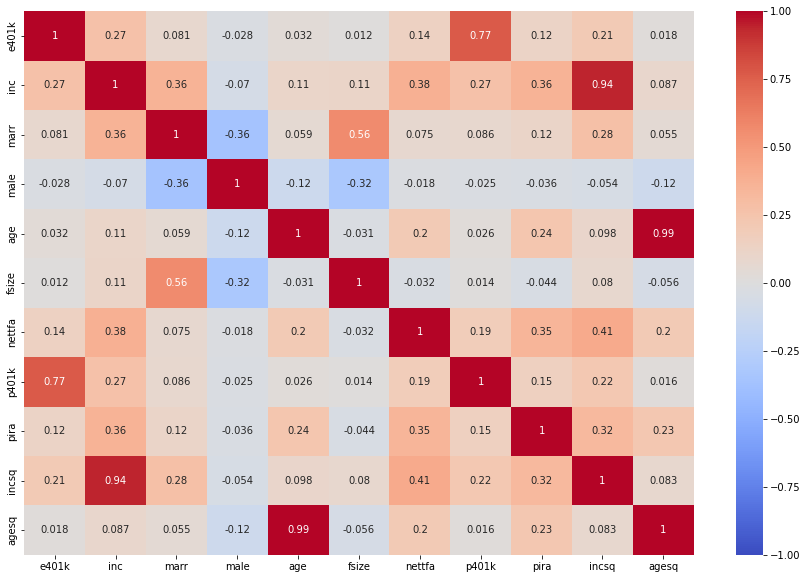

In [235]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),annot=True,cmap='coolwarm',vmin=-1,vmax=1);

Regression: feature that best predict income is nett financial asset. Limitation is that we only see the linear relation with 